In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, DistributedSampler
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorboardX import SummaryWriter
import time
from skimage import io, transform

In [2]:
import cv2

# Make folder to save model and tensorboard

In [3]:
date_folder='20230824_1/'

output_dir=os.path.join(date_folder,'out/')

tensorboard_dir=os.path.join(date_folder,'tensorboard/')
checkpoints_dir=os.path.join(date_folder,'ckpts/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

In [4]:
date_folder

'20230824_1/'

In [5]:
tensorboard_dir

'20230824_1/tensorboard/'

# Build Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Backbone_VGG(nn.Module):
    def __init__(self):
        super(Backbone_VGG, self).__init__()
        self.body1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.body2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.body3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.body4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        out1 = self.body1(x)
        out2 = self.body2(out1)
        out3 = self.body3(out2)
        out4 = self.body4(out3)
        
        return out1, out2, out3, out4


class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(256, 8, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 2)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in=256, num_anchor_points=4, num_classes=2, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchor_points = num_anchor_points

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchor_points * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()
        
    # sub-branch forward
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.output(out)

        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, _ = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchor_points, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

class AnchorPoints(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, row=3, line=3):
        super(AnchorPoints, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        else:
            self.pyramid_levels = pyramid_levels

        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]

        self.row = row
        self.line = line

    def forward(self, image):
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        all_anchor_points = np.zeros((0, 2)).astype(np.float32)
        # get reference points for each level
        for idx, p in enumerate(self.pyramid_levels):
            anchor_points = generate_anchor_points(2**p, row=self.row, line=self.line)
            shifted_anchor_points = shift(image_shapes[idx], self.strides[idx], anchor_points)
            all_anchor_points = np.append(all_anchor_points, shifted_anchor_points, axis=0)

        all_anchor_points = np.expand_dims(all_anchor_points, axis=0)
        # send reference points to device
        if torch.cuda.is_available():
            return torch.from_numpy(all_anchor_points.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchor_points.astype(np.float32))
def generate_anchor_points(stride=16, row=3, line=3):
    row_step = stride / row
    line_step = stride / line

    shift_x = (np.arange(1, line + 1) - 0.5) * line_step - stride / 2
    shift_y = (np.arange(1, row + 1) - 0.5) * row_step - stride / 2

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    anchor_points = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    return anchor_points

def shift(shape, stride, anchor_points):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    A = anchor_points.shape[0]
    K = shifts.shape[0]
    all_anchor_points = (anchor_points.reshape((1, A, 2)) + shifts.reshape((1, K, 2)).transpose((1, 0, 2)))
    all_anchor_points = all_anchor_points.reshape((K * A, 2))

    return all_anchor_points


class Decoder(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(Decoder, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)


    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        return [P3_x, P4_x, P5_x]


class P2PNet(nn.Module):
    def __init__(self):
        super(P2PNet, self).__init__()
        self.backbone = Backbone_VGG()
        self.regression = RegressionModel()
        self.classification = ClassificationModel()
        self.anchor_points = AnchorPoints(pyramid_levels=[3,], row=2, line=2)
        self.fpn =  Decoder(256, 512, 512)

    def forward(self, x):
        features = self.backbone(x)
        features_fpn = self.fpn([features[1], features[2], features[3]])
        
        batch_size = features[0].shape[0]
        regression_out = self.regression(features_fpn[1]) * 100 # 8x
        classification_out = self.classification(features_fpn[1])
        anchor_points_out = self.anchor_points(x).repeat(batch_size, 1, 1)
        
        output_coord = regression_out.to(device) + anchor_points_out.to(device)
        
        output_class = classification_out
        out = {'pred_logits': output_class, 'pred_points': output_coord}
       
        return out


In [7]:
# # Create an instance of the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # device='cpu'
# model = P2PNet()
# PATH='D:/best_mae (1).pth'
# # PATH=checkpoints_dir+'/latest.pth'

# checkpoint = torch.load(PATH, map_location=device)
# model.load_state_dict(checkpoint['model'])
# model.to(device)
# model.eval();

In [8]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
model = P2PNet()
model.to(device);

In [9]:
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

def loading_data(data_root):
    # the pre-proccssing transform
    transform = standard_transforms.Compose([
        standard_transforms.ToTensor(), 
        standard_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
    ])
    # create the training dataset
    train_set = SHHA(data_root, train=True, transform=transform, patch=True, flip=True)
    # create the validation dataset
    val_set = SHHA(data_root, train=False, transform=transform)

    return train_set, val_set

# Custom Dataset

In [10]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import cv2
import glob
import scipy.io as io

class SHHA(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(root_dir, filename)
                self.images.append(img_path)
                
                label = os.path.join(root_dir, filename[:-4]+'.txt')
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'

        img_path = self.images[index]
        gt_path = self.labels[index]
        # load image and ground truth
        img, point = load_data((img_path, gt_path))
        # applu augumentation
        if self.transform is not None:
            img = self.transform(img)

        if True:
            # data augmentation -> random scale
            scale_range = [0.7, 1.3]
            min_size = min(img.shape[1:])
            scale = random.uniform(*scale_range)
            # scale the image and points
            if scale * min_size > 128:
                img = torch.nn.functional.upsample_bilinear(img.unsqueeze(0), scale_factor=scale).squeeze(0)
                point *= scale
        # random crop augumentaiton
        if True:
            img, point = random_crop(img, point)
            for i, _ in enumerate(point):
                point[i] = torch.Tensor(point[i])
        # random flipping
        if True:
            # random flip
            img = torch.Tensor(img[:, :, :, ::-1].copy())
            for i, _ in enumerate(point):
                point[i][:, 0] = 128 - point[i][:, 0]

        if not True:
            point = [point]

        img = torch.Tensor(img)
        # pack up related infos
        target = [{} for i in range(len(point))]
        for i, _ in enumerate(point):
            target[i]['point'] = torch.Tensor(point[i])
            image_id = int(img_path.split('/')[-1].split('.')[0].split('_')[-1])
            image_id = torch.Tensor([image_id]).long()
            target[i]['image_id'] = image_id
            target[i]['labels'] = torch.ones([point[i].shape[0]]).long()

        return img, target


def load_data(img_gt_path):
    img_path, gt_path = img_gt_path
    # load the images
    img = cv2.imread(img_path)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # load ground truth points
    points = []
    with open(gt_path) as f_label:
        for line in f_label:
            x = float(line.strip().split(' ')[0])
            y = float(line.strip().split(' ')[1])
            points.append([x, y])

    return img, np.array(points)

# random crop augumentation
def random_crop(img, den, num_patch=2):
    half_h = 128
    half_w = 128
    result_img = np.zeros([num_patch, img.shape[0], half_h, half_w])
    result_den = []
    # crop num_patch for each image
    for i in range(num_patch):
        start_h = random.randint(0, img.size(1) - half_h)
        start_w = random.randint(0, img.size(2) - half_w)
        end_h = start_h + half_h
        end_w = start_w + half_w
        # copy the cropped rect
        result_img[i] = img[:, start_h:end_h, start_w:end_w]
        # copy the cropped points
        idx = (den[:, 0] >= start_w) & (den[:, 0] <= end_w) & (den[:, 1] >= start_h) & (den[:, 1] <= end_h)
        # shift the corrdinates
        record_den = den[idx]
        record_den[:, 0] -= start_w
        record_den[:, 1] -= start_h

        result_den.append(record_den)

    return result_img, result_den

In [11]:
def collate_fn_crowd(batch):
    # re-organize the batch
    batch_new = []
    for b in batch:
        imgs, points = b
        if imgs.ndim == 3:
            imgs = imgs.unsqueeze(0)
        for i in range(len(imgs)):
            batch_new.append((imgs[i, :, :, :], points[i]))
    batch = batch_new
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
])
# create the training dataset
train_set = SHHA('/scratch/user/piyalong/20230426CDI/data/train/', transform=transform)
# create the validation dataset
val_set = SHHA('/scratch/user/piyalong/20230426CDI/data/test/',transform=transform)

In [13]:
batch_size=16
data_loader_train = DataLoader(train_set, batch_size=batch_size, collate_fn=collate_fn_crowd,shuffle=True)
data_loader_test = DataLoader(val_set, batch_size=batch_size, collate_fn=collate_fn_crowd,shuffle=True)

# Show some annotation examples

In [14]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [15]:
from typing import Optional, List
from torch import Tensor
def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:

        # TODO make it support different-sized images
        max_size = _max_by_axis_pad([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        for img, pad_img in zip(tensor_list, tensor):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    else:
        raise ValueError('not supported')
    return tensor

def _max_by_axis_pad(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)

    block = 128

    for i in range(2):
        maxes[i+1] = ((maxes[i+1] - 1) // block + 1) * block
    return maxes

/scratch/user/piyalong/.conda/envs/jupyterlab2/lib/python3.8/site-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) 1.0000001


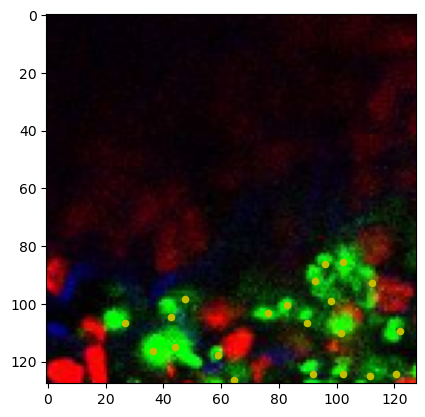

In [16]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

for batch_images, batch_labels in data_loader_test:
    for image,target in zip(batch_images, batch_labels):
        image=unorm(image)
        landmarks=target['point']
        image_numpy=image.cpu().numpy().copy()
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
        if len(landmarks)>5:
            print(image_numpy.shape,image_numpy.max())
            plt.imshow(image_numpy)
            plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='o', c='y')
            break
    # break

# Evaluation

## Hungarian match again to see TP. This matching is different from the training match because training matches every possible point. 

# Old loss function

In [17]:
class SetCriterion_Crowd(nn.Module):

    def __init__(self, num_classes, matcher,losses = ['labels', 'points']):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = HungarianMatcher_Crowd()
        self.weight_dict = {'loss_ce': 1, 'loss_points': 0.5}
        # self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[0] = 1
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_points):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']
        # print(indices)
        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)]).to(device)
        target_classes = torch.full(src_logits.shape[:2], 0,
                                    dtype=torch.int64, device=device)
        target_classes[idx] = target_classes_o
        # print(src_logits.transpose(1, 2).device,target_classes.device)
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2).to(device), target_classes, self.empty_weight.to(device))
        

        losses = {'loss_ce': loss_ce}

        return losses

    def loss_points(self, outputs, targets, indices, num_points):

        assert 'pred_points' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_points = outputs['pred_points'][idx]
        target_points = torch.cat([t['point'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.mse_loss(src_points.to(device), target_points.to(device), reduction='none')

        losses = {}
        losses['loss_point'] = loss_bbox.sum() / num_points

        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_points, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'points': self.loss_points,
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_points, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        output1 = {'pred_logits': outputs['pred_logits'], 'pred_points': outputs['pred_points']}

        indices1 = self.matcher(output1, targets)

        num_points = sum(len(t["labels"]) for t in targets)
        num_points = torch.as_tensor([num_points], dtype=torch.float, device=next(iter(output1.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_points)
        num_boxes = torch.clamp(num_points / get_world_size(), min=1).item()

        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, output1, targets, indices1, num_boxes))

        return losses
        
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

In [18]:
import torch
from scipy.optimize import linear_sum_assignment
from torch import nn
import torch.distributed as dist

class HungarianMatcher_Crowd(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network

    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_point: float = 1):
        """Creates the matcher

        Params:
            cost_class: This is the relative weight of the foreground object
            cost_point: This is the relative weight of the L1 error of the points coordinates in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_point = cost_point
        assert cost_class != 0 or cost_point != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching

        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "points": Tensor of dim [batch_size, num_queries, 2] with the predicted point coordinates

            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_points] (where num_target_points is the number of ground-truth
                           objects in the target) containing the class labels
                 "points": Tensor of dim [num_target_points, 2] containing the target point coordinates

        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_points)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_points = outputs["pred_points"].flatten(0, 1).cpu()  # [batch_size * num_queries, 2]

        # Also concat the target labels and points
        # tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_points = torch.cat([v["point"] for v in targets]).cpu()

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids].cpu()
        # print(tgt_ids.shape)
        # Compute the L2 cost between point
        cost_point = torch.cdist(out_points, tgt_points, p=2).cpu()

        # Compute the giou cost between point

        # Final cost matrix
        C = self.cost_point * cost_point + self.cost_class * cost_class
        C = C.view(bs, num_queries, -1).cpu()
        sizes = [len(v["point"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]

        # print(C.shape)

        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

In [19]:
matcher=HungarianMatcher_Crowd()

criterion = SetCriterion_Crowd(1,  matcher=matcher)
# idx

In [20]:
for batch_images, batch_labels in data_loader_train:
    outputs = model(batch_images.to(device))
    criterion(outputs,batch_labels)


In [21]:
outputs['pred_logits'].size()

torch.Size([4, 1024, 2])

In [22]:
idx=matcher(outputs,batch_labels)
criterion(outputs,batch_labels)

{'loss_ce': tensor(0.7052, device='cuda:0', grad_fn=<NllLoss2DBackward0>),
 'loss_point': tensor(2.7312, device='cuda:0', grad_fn=<DivBackward0>)}

# Transfer Learning

In [23]:
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [ ]:
import math
matcher=HungarianMatcher_Crowd()
criterion = SetCriterion_Crowd(1,  matcher=matcher)

train_writer = SummaryWriter(tensorboard_dir+'train/')
test_writer = SummaryWriter(tensorboard_dir+'test/')

loss_history=[]
train_step=test_step=0

# Adam is used by default
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001 )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose =True)
# iterate all training samples
for epoch in range(1000):
    model.train()
    criterion.train()  
    for samples, targets in data_loader_train:
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # forward
        outputs = model(samples)
        criterion(outputs,targets)
        # calc the losses
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # reduce all losses
        loss_dict_reduced = reduce_dict(loss_dict)
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
        # backward
        optimizer.zero_grad()
        losses.backward()
        if 0.1 > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    if train_writer is not None:
        train_writer.add_scalar('train/loss', losses, epoch)

    checkpoint_latest_path = os.path.join(checkpoints_dir, 'latest.pth')
    torch.save({ 'model': model.state_dict(),}, checkpoint_latest_path)

    print("Epoch {}, Train_loss: {}".format(epoch,loss_value))

    #Evaluation
    torch.no_grad()
    model.eval()
    for samples, targets in data_loader_train:
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # forward
        outputs = model(samples)
        criterion(outputs,targets)
        # calc the losses
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        loss_eval = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        loss_history.append(loss_eval.detach().cpu().numpy()) 
        test_step+=1
    if test_writer is not None:
        test_writer.add_scalar('test/loss_eval',loss_eval, epoch)
    print("Epoch {}, Val_loss: {}".format(epoch,loss_eval))
    
    if abs(np.min(loss_history) - loss_eval) < 0.01:
        checkpoint_best_path = os.path.join(checkpoints_dir, 'best_mae.pth')
        torch.save({
            'model': model.state_dict(),
        }, checkpoint_best_path)    



In [31]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
model = P2PNet()
PATH='/scratch/user/piyalong/P2PNet/20230824_1/ckpts/best_mae.pth'
# PATH=checkpoints_dir+'/latest.pth'

checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval();

In [62]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.targets = []
        
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(root_dir, filename)
                self.images.append(img_path)
                
                target = os.path.join(root_dir, filename[:-4]+'.txt')
                self.targets.append(target)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        assert idx <= len(self), 'index range error'
        img_path = self.images[idx]
        gt_path = self.targets[idx]
        
        image_bgr = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        points = []
        with open(gt_path) as f_label:
            for line in f_label:
                x = float(line.strip().split(' ')[0])
                y = float(line.strip().split(' ')[1])
                points.append([x, y])
        
        target={}
        target['point'] = torch.Tensor(points)
        target['image_ids']=torch.Tensor(idx)
        target['labels'] = torch.ones(len(points)).long()
        
        new_size=(1024,1024)
        img, target=resize_image_with_annotations(image_rgb,target,new_size)
        # img=image_rgb
        img = self.transform(img) 
        
        return img, target


datatransform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],    std=[0.229, 0.224, 0.225]),
                                    # transforms.Resize(new_size),   
                                           ])



In [63]:
def collate_fn(batch):
    images = list()
    targets = list()

    for img, target in batch:
        images.append(img)
        targets.append(target)
    
    images = torch.stack(images, dim=0)
    
    return images.float().to(device), targets 

In [64]:
batch_size=2

# dataset_train=CustomDataset('D:/20230426CDI/data/train/',datatransform)

# data_loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn,shuffle=True)

dataset_test=CustomDataset('/scratch/user/piyalong/20230426CDI/data/test/',datatransform)
# dataset_test=CustomDataset('D:/20230427_New_Dataset-20230824T214952Z-001/20230427_New_Dataset/new_data/data/test/',datatransform)

data_loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn,shuffle=True)

In [65]:
def resize_image_with_annotations(image, target, new_size):
    # Open the image
    h, w = image.shape[:2]
    points=target['point']
    # Calculate the scaling factors for x and y dimensions
    scale_x = new_size[0] / w
    scale_y = new_size[1] / h

    # Resize the image
    resized_image = cv2.resize(image,new_size)

    # Resize and adjust the point annotations
    resized_points = [(int(x * scale_x), int(y * scale_y)) for x, y in points]
    target['point']= torch.Tensor(resized_points)
    return resized_image, target

In [66]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def match_resutls(predicted_points, gt_points):

    if len(predicted_points) >= len(gt_points):
        n_rows =n_cols=len(predicted_points)
    else:
        n_cols = n_rows =len(gt_points)

    cost_matrix = np.zeros((n_rows, n_cols))

    for i, pred_point in enumerate(predicted_points):
        for j, gt_point in enumerate(gt_points):
            cost_matrix[i, j] = euclidean_distance(pred_point, gt_point)
            
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    return cost_matrix, row_indices, col_indices

1
 TP 1 precision 1.0 recall 0.08333333333333333


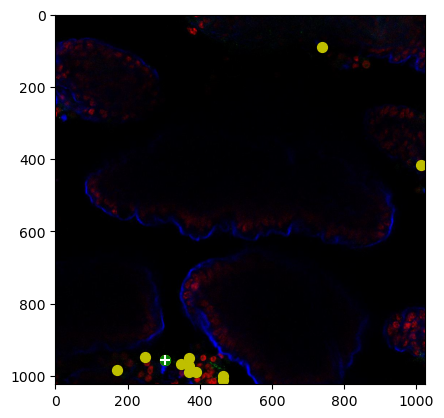

3
 TP 2 precision 1.0 recall 0.4


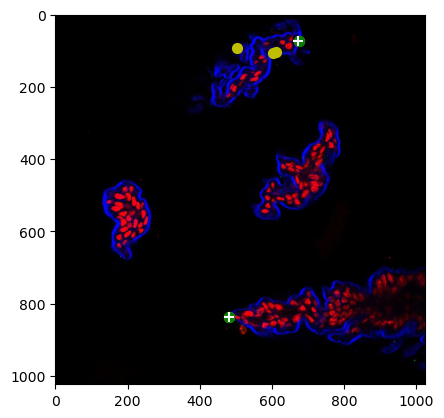

6
 TP 3 precision 1.0 recall 0.2727272727272727


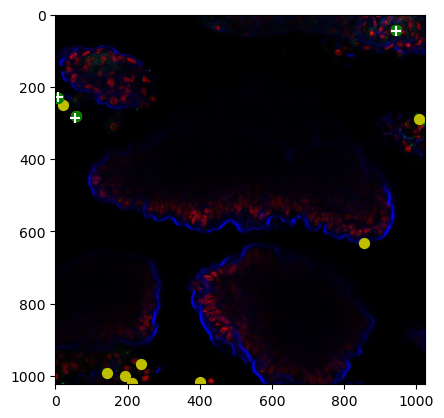

9
 TP 3 precision 1.0 recall 0.3333333333333333


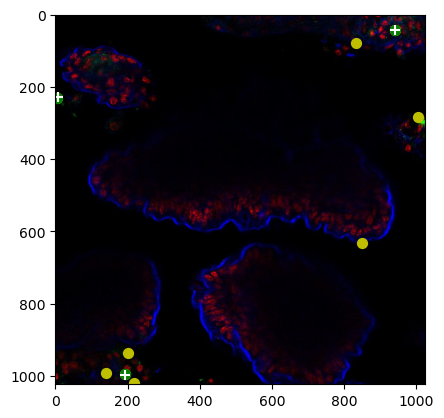

20
 TP 11 precision 0.8461538461538461 recall 0.1864406779661017


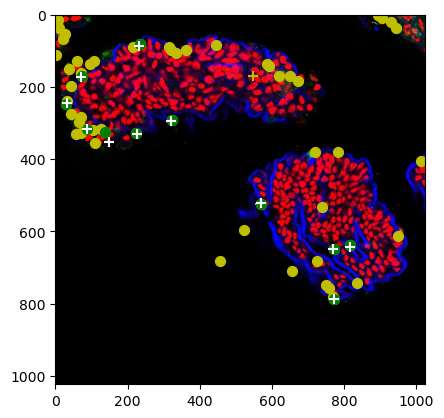

22
 TP 2 precision 1.0 recall 0.2857142857142857


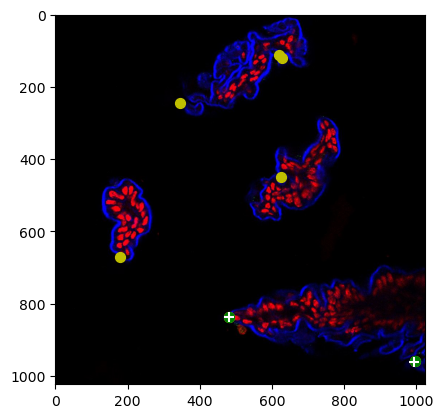

24
 TP 2 precision 1.0 recall 0.1


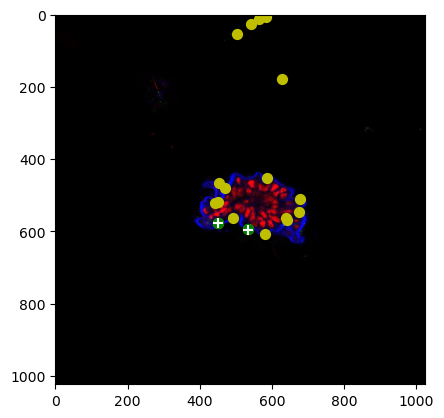

32
 TP 8 precision 0.7272727272727273 recall 0.47058823529411764


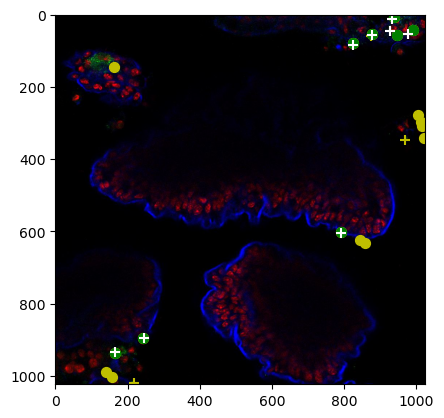

44
 TP 12 precision 1.0 recall 0.2033898305084746


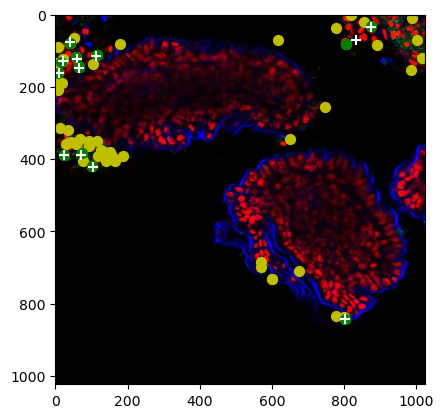

46
 TP 2 precision 1.0 recall 0.15384615384615385


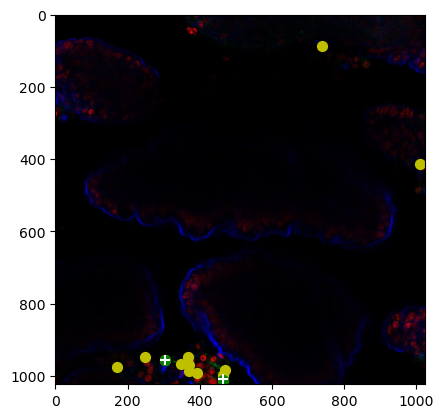

52
 TP 6 precision 1.0 recall 0.25


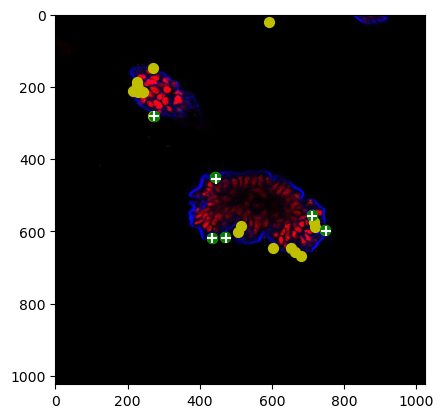

67
 TP 15 precision 1.0 recall 0.23076923076923078


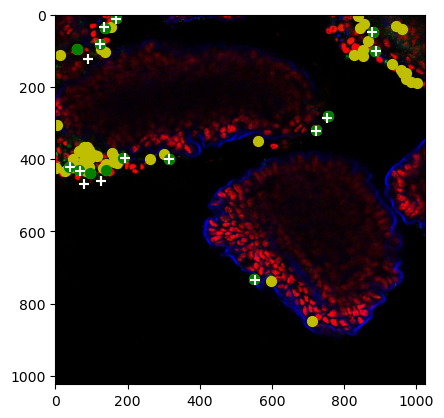

74
 TP 7 precision 1.0 recall 0.2413793103448276


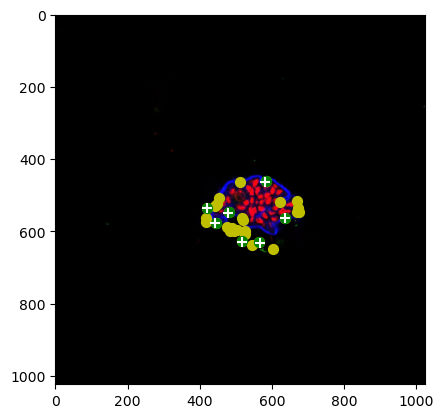

90
 TP 16 precision 0.9411764705882353 recall 0.26666666666666666


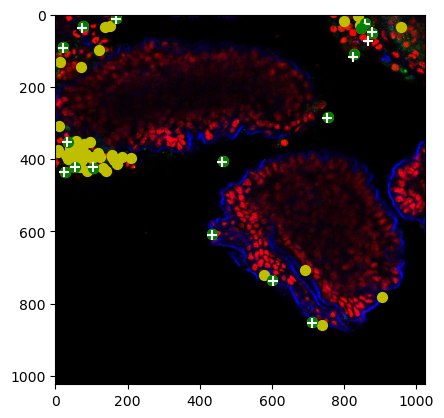

91
 TP 1 precision 1.0 recall 0.3333333333333333


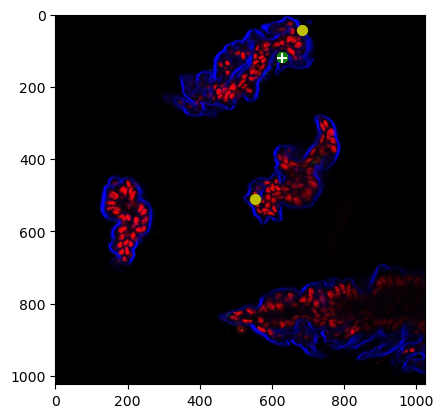

91


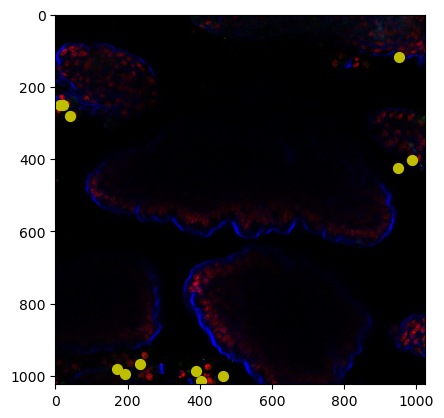

94
 TP 3 precision 1.0 recall 0.21428571428571427


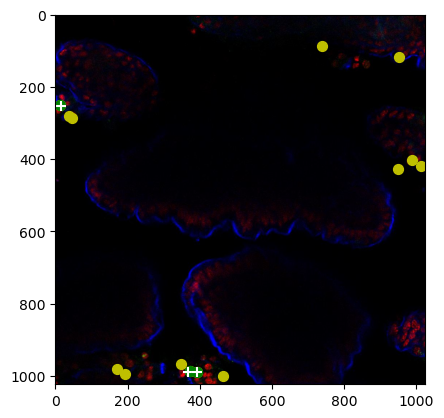

97
 TP 3 precision 1.0 recall 0.42857142857142855


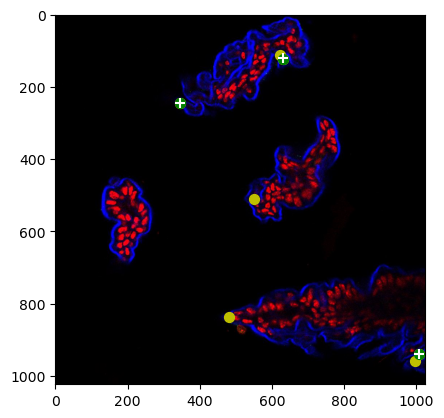

105
 TP 8 precision 0.7272727272727273 recall 0.5714285714285714


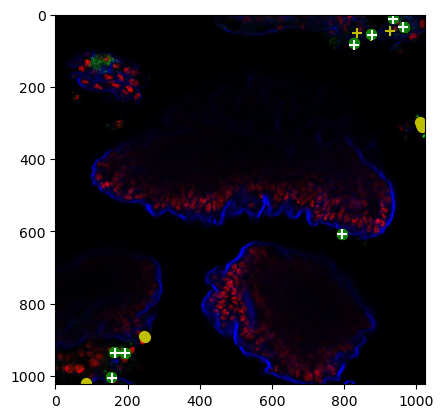

106
 TP 1 precision 1.0 recall 0.08333333333333333


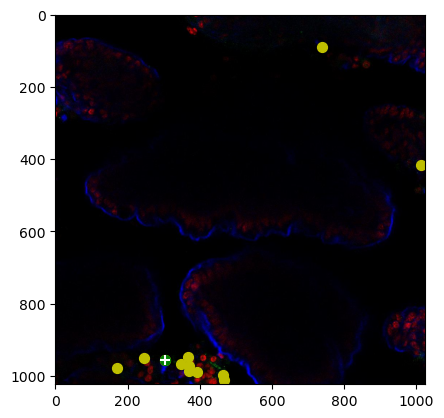

122
 TP 16 precision 1.0 recall 0.32653061224489793


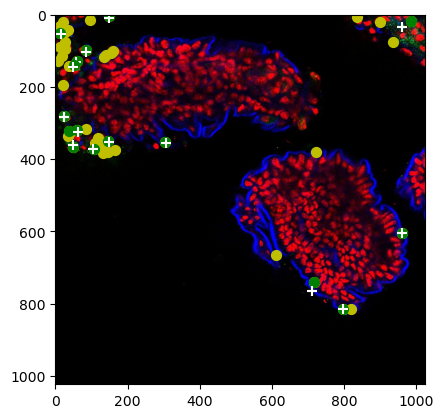

total TP 122 precision 0.9312977099236641 recall 0.2435129740518962


In [71]:
total_tp=total_gt=total_pred=0
i=0

for batch_images, batch_labels in data_loader_test:
    with torch.no_grad():
        outputs =     model(batch_images.to(device))

    for image,target,pred_logits, pred_points in zip(batch_images, batch_labels,outputs['pred_logits'],outputs['pred_points']):
        image=unorm(image)
        outputs_scores = torch.nn.functional.softmax(pred_logits, -1)[:, 1]
        points = pred_points[outputs_scores > 0.45].cpu().numpy()
        
        image_numpy = np.transpose(image.cpu(), (1, 2, 0))
        img_to_draw=image_numpy.numpy().copy() 
                
        y_true=target['point'].detach().cpu().numpy()
        
        cost_matrix,row_indices, col_indices=match_resutls(points, y_true)
        size=50
        tp=0

        yellow2=plt.scatter(y_true[:, 0], y_true[:, 1], s=size, marker='o', c='y', label='GT')
        yellow1=plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='y', label='CV')
        
        for row, col in zip(row_indices, col_indices):
            if row < len(points) and col < len(y_true):
                pred_point = points[row]
                gt_point = y_true[col]
                if cost_matrix[row, col]<size:
                    circles=plt.scatter(gt_point[0], gt_point[1], s=size, marker='o', c='g', label='GT')
                    crosses=plt.scatter(pred_point[0], pred_point[1], s=size, marker='+', c='w', label='CV')
                    tp+=1
        
        total_tp+=tp
        total_gt+=len(y_true)
        total_pred+=len(points)
        if total_tp>0:
            print(total_tp)
            if len(y_true)!=0 and len(points)!=0:
                print(f' TP {tp} precision {tp/len(points) } recall {tp/len(y_true)}')
            # print(target['image_ids'].numpy())
            # custom_legend_labels = ['TP CV', 'TP GT', 'Unmatched CV','Unmatched GT']
            # custom_legend_handles = [crosses, circles,yellow1,yellow2]
            # # Add a custom legend
            # plt.legend(custom_legend_handles, custom_legend_labels)
            plt.imshow(img_to_draw)
            # plt.savefig(f'Evaluation/{i}.jpg',bbox_inches='tight')
            plt.show()

        i+=1
        # break
    # break
print(f'total TP {total_tp} precision {total_tp/total_pred } recall {total_tp/total_gt}')

In [40]:
outputs_scores.max()

tensor(0.6048, device='cuda:0')

In [70]:
len(points)

0

In [35]:
target['point']

tensor([], size=(0, 2))